In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

## Reading in Flare data for GJ1243 and masking out the flares

In [2]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   '(ED) in units of per seconds','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [3]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']

In [4]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

In [5]:
gj1243lc = gj1243_collection[0].PDCSAP_FLUX

for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX)
    except:
            print(q)

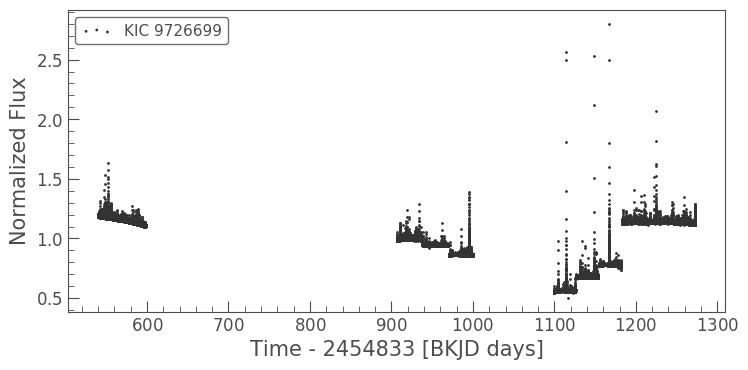

In [6]:
gj1243lc.scatter()

In [7]:
#comparing to Jim's lightcurve
jimlc=np.loadtxt('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/1732d4130daf663532596749d566d8f78be8f7b2/data/gj1243_master_slc.dat')

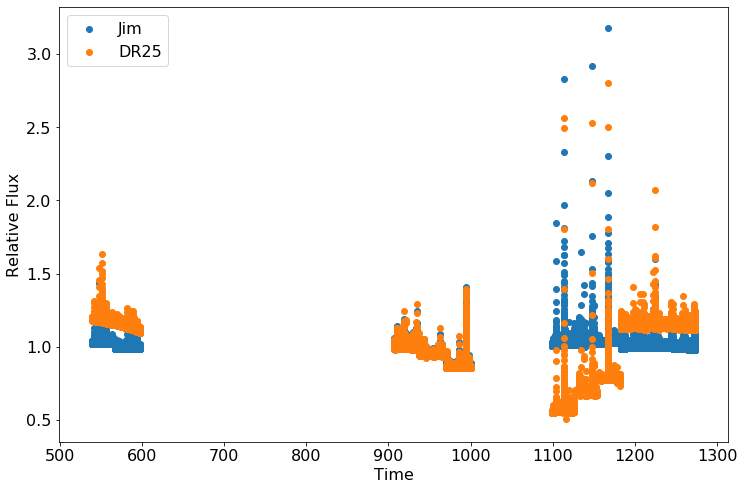

In [8]:
tiempo=jimlc[:,0]
flujo=jimlc[:,1]

fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)
plt.scatter(tiempo,flujo/np.nanmedian(flujo),label=('Jim'))
plt.scatter(gj1243lc.time,gj1243lc.flux/np.nanmedian(gj1243lc.flux),label=('DR25'))
plt.ylabel('Relative Flux')
plt.xlabel('Time')
plt.legend(loc='upper left')

In [ ]:
#one month of data
un_mes=gj1243_collection[0].PDCSAP_FLUX
un_mes.scatter()
plt.xlim(539.4,540.4)
plt.ylim(1.,1.1)

#Why is the flux with flares lower?
#diff median 

In [ ]:
gj1243lc

In [ ]:
gj1243lc.scatter()
plt.xlim(539.4,540.4)
plt.ylim(1.17,1.22)

In [11]:
#creates array same shape as kepler time (or whatever data you give)
f_mask = np.zeros_like(gj1243lc.time, dtype=bool)

In [12]:
#mask array
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 1
    c2 = 2 #play with these buffers 
    buffer = (gj1243lc.time >= t_starts[i] - c1*dur) & (gj1243lc.time <= t_stops[i] + c2*dur)
    temp = (gj1243lc.time >= t_starts[i]) & (gj1243lc.time <= t_stops[i])
    f_mask = f_mask + temp
print(f_mask)

[False False False ... False False False]


In [17]:
#mask array for Jim's lightcurve
f_mask_j = np.zeros_like(tiempo, dtype=bool)
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 1
    c2 = 2 #play with these buffers 
    buffer = (tiempo >= t_starts[i] - c1*dur) & (tiempo <= t_stops[i] + c2*dur)
    temp = (tiempo >= t_starts[i]) & (tiempo <= t_stops[i])
    f_mask_j = f_mask_j + temp
print(f_mask_j)

[False False False ... False False False]


In [ ]:
f_mask_un_mes = np.zeros_like(un_mes.time, dtype=bool)

#mask array for one month of data
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 1
    c2 = 2 #play with these buffers 
    buffer = (un_mes.time >= t_starts[i] - c1*dur) & (un_mes.time <= t_stops[i] + c2*dur)
    temp = (un_mes.time >= t_starts[i]) & (un_mes.time <= t_stops[i])
    f_mask_un_mes = f_mask_un_mes + temp
print(f_mask_un_mes)

In [ ]:
un_mes.scatter()

In [ ]:
plt.plot(un_mes.time,un_mes.flux/np.nanmedian(un_mes.flux))

### One month of flare-less data

In [13]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

no_flare_un_mes = np.where((f_mask_un_mes == False))[0]
plt.scatter(un_mes.time[no_flare_un_mes],un_mes.flux[no_flare_un_mes]/np.nanmedian(un_mes.flux[no_flare_un_mes]))
#plt.xlim(539.4,540.4)
#plt.ylim(1.17,1.22)
#plt.xlim(1190,1200)
plt.xlabel('Time')
plt.ylabel('Normalized Flux')


#outling points are probably overlaps from rise and decays of other flares

NameError: name 'f_mask_un_mes' is not defined

<Figure size 864x576 with 0 Axes>

## Plot shows (non-flat) flare-less data

Text(0, 0.5, 'Normalized Flux')

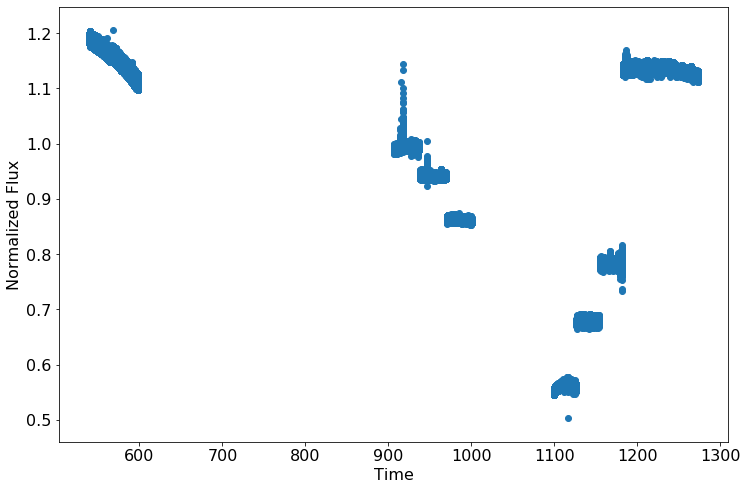

In [14]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

no_flare = np.where((f_mask == False))[0]
plt.scatter(gj1243lc.time[no_flare],gj1243lc.flux[no_flare]/np.nanmedian(gj1243lc.flux))
#plt.xlim(567.55,568)
#plt.xlim(539.4,540.4)
#plt.ylim(1.17,1.22)
#plt.xlim(1178,1179.5)
plt.xlabel('Time')
plt.ylabel('Normalized Flux')

#We should mask the flare + a little window to account for human error in flare identification 
#(buffer ~(t_stop-t_start /2) or else the gp will get part of the decay phase of the flare

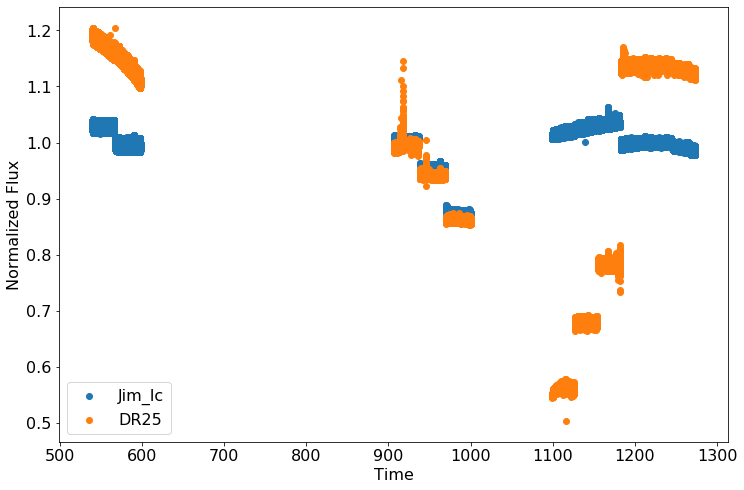

In [18]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

no_flare = np.where((f_mask == False))[0]
no_flare_j = np.where((f_mask_j == False))[0]
plt.scatter(tiempo[no_flare_j],flujo[no_flare_j]/np.nanmedian(flujo),label=('Jim_lc'))
plt.scatter(gj1243lc.time[no_flare],gj1243lc.flux[no_flare]/np.nanmedian(gj1243lc.flux),label=('DR25'))
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.legend()

In [ ]:
gj1243lc.time[no_flare]

### Removing leftover flares

In [ ]:
#extra_flares_mask = np.zeros_like(gj1243lc.time, dtype=bool)

#mask array for one month of data
#for i in range(len(t_starts)):
#    temp1 = (gj1243lc.time >= t_starts[i]) & (gj1243lc.time <= t_stops[i])
#    extra_flares_mask = extra_flares_mask + temp1
#print(extra_flares_mask)

In [ ]:
extra_flares_table=pd.read_csv('extra_flares',skiprows=3,delim_whitespace=True,names=['t_start','t_stop'])
t_starts_extra=extra_flares_table.loc[:,'t_start']
t_stops_extra=extra_flares_table.loc[:,'t_stop']
#first one might be outlier

In [ ]:
extra_flares_table

### Now we want to run celerite on this data that has all the flares masked starting with one month of data

In [ ]:
y = un_mes.flux[no_flare_un_mes]/np.nanmedian(un_mes.flux[no_flare_un_mes])
t = un_mes.time[no_flare_un_mes]
yerr = un_mes.flux_err[no_flare_un_mes]

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15,15), log_Q=(-15,15), log_omega0=(-15,15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [ ]:
'''
y = gj1243lc.flux[no_flare]/np.nanmedian(gj1243lc.flux)
t = gj1243lc.time[no_flare]
yerr = gj1243lc.flux_err[no_flare]

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-50,50), log_Q=(-10,10), log_omega0=(-10,10))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)


This does not work all at once, need to spilt it up into one month of data
'''


In [ ]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

In [ ]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

In [ ]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

In [ ]:
gp.get_parameter_dict()

In [ ]:
x = np.linspace(539,565, 10)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

The 1-sigma prediction is shown as an orange band and the mean prediction is indicated by a solid orange line. Comparing this to the true underlying function (shown as a blue-gray line), we see that the prediction is not consistent with the truth at all times. Something went wrong


In [ ]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

color = "#ff7f0e"
#plt.plot(gj1243lc.time[no_flare],gj1243lc.flux[no_flare]/np.nanmedian(gj1243lc.flux),  lw=1, alpha=0.5)
#plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.xlim(539,565)
#plt.ylim(-2.5, 2.5);


plt.plot(un_mes.time[no_flare_un_mes],un_mes.flux[no_flare_un_mes]/np.nanmedian(un_mes.flux), lw=1,alpha=0.5)

The following figure shows the model power spectrum as a solid line and the dashed lines show the contributions from the two components.

In [ ]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");